# Default Payment Prediction

## Problem
- Bank ingin mengingatkan nasabah yang belum membayar kartu kredit pada bulan depan, namun menghubungi semua nasabah tentu menghabiskan cost yang lebih banyak sehingga perlu dilakukan prediksi customer mana berpotensi akan menunggak (default payment) supaya mereka bisa membayar secara tepat waktu.

## Goals
- Mempertahankan dan meningkatkan revenue perusahaan/bank.
- Meminimalkan modal/cost menelfon/mengingatkan nasabah.


## Import Common Package

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dython.nominal import associations, cramers_v, correlation_ratio, theils_u

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import joblib


pd.set_option('display.max_rows', 300)


import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [3]:
df=pd.read_excel("CreditCard.xls",skiprows=1)
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


## Penjelasan dataset :
### Ini merupakan data Harga dari beberapa Credit Card yg menunggak bayar
## Penjelasan kolom/feature
- Limit_bal : amount the given credit (NT Dollar). it include consumer credit and his/her family(suplementary) credit (jumlah limit)
- gender (1: male, 2 : female)
- education(1:graduate school, 2:university, 3: high school, 4:others)
- marital status(1:married,2:single,3: others)
- age(years)
- pay_ : histroy of past payment , from april-september 2005 , pay_1 : september, pay_2: agustus, pay_3:july,..., pay_6:april,
    - -1 :pay duly (membayar lunas)
    - 0 :gada tunggakan
    - 1 : delay 1 bulan
    - 2: delay 2 bulan
    - dst
- bill_amt_ : amount of bill statement (jumlah tagihan) , _1:september, _2:agustus,..., _6:april
- pay_amt_ : amount of previous statement (jumlah tagihan sebelumnya) : _1:jumlah yang dibayar di september, _2:jumlah yang dibayar di agustus, ..,_6:jumlah yang dibayar di april 2005
- target : default payment next month , 1 :yes , 0: no (nunggak atau ngga bulan depan)
    


In [4]:
#melihat tipe data dari masing2 kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [5]:
#Melihat deskripsi statistik dataset
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [6]:
#merename kolom target
df.rename(columns={'default payment next month':'Target','PAY_0':'PAY_1'},inplace=True)

In [7]:
#melihat unique sample masing2 kolom
cc = []
for i in df.columns:
    cc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        (((df[i].isna().sum()) / len(df)) * 100).round(2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = cc, columns= [
    'Data Feature',
    'Data Types',
    'Null',
    'Null Pct',
    'Unique',
    'Unique Sample'
] )

,Data Feature,Data Types,Null,Null Pct,Unique,Unique Sample
0,ID,int64,0,0.0,30000,"[25925, 8913]"
1,LIMIT_BAL,int64,0,0.0,81,"[560000, 40000]"
2,SEX,int64,0,0.0,2,"[1, 2]"
3,EDUCATION,int64,0,0.0,7,"[3, 1]"
4,MARRIAGE,int64,0,0.0,4,"[1, 3]"
5,AGE,int64,0,0.0,56,"[25, 56]"
6,PAY_1,int64,0,0.0,11,"[6, 7]"
7,PAY_2,int64,0,0.0,11,"[3, -1]"
8,PAY_3,int64,0,0.0,11,"[-1, 0]"
9,PAY_4,int64,0,0.0,11,"[8, -2]"


#### tidak ada missing value

## Cek Outliers / Data abnormal

<Figure size 1080x720 with 0 Axes>

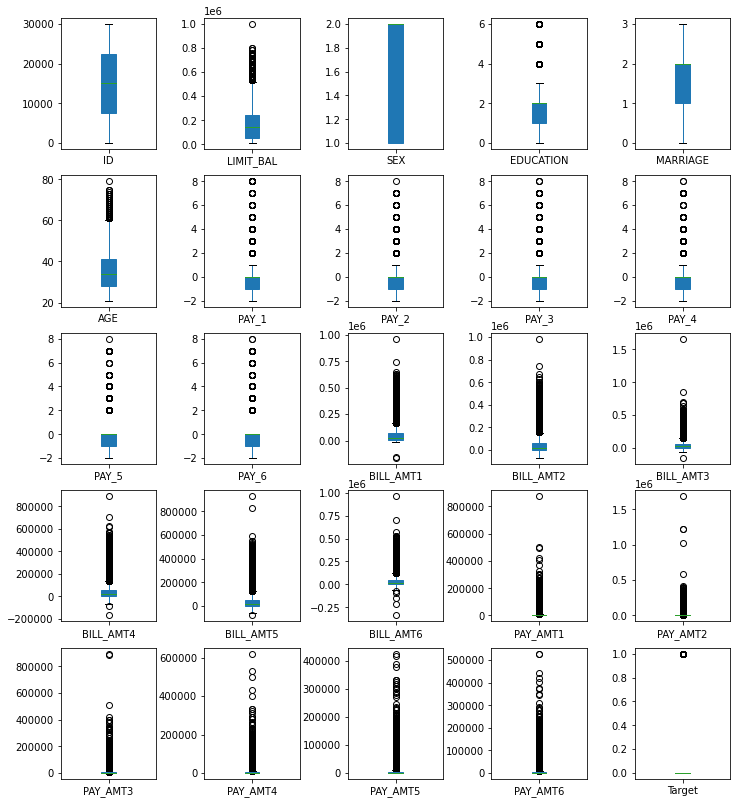

In [8]:
# subplots
plt.figure(figsize=(15,10))
df.plot(subplots=True, layout=(5,5), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);
plt.show()

In [9]:
df['LIMIT_BAL'].min()

10000

In [10]:
# melihat data abnormal pada masing2 kolom
# education(1:graduate school, 2:university, 3: high school, 4:others)
df['EDUCATION'].unique()
#0,5,6 abnormal


array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [11]:
##menganmbil data selain 0,5 dan 6
df = df[(df['EDUCATION']!=0 ) & (df['EDUCATION']!=5 ) & (df['EDUCATION']!=6)]
df['EDUCATION'].unique()

array([2, 1, 3, 4], dtype=int64)

In [12]:
# melihat data abnormal pada masing2 kolom
# marital status(1:married,2:single,3: others)
df['MARRIAGE'].unique()
#0


array([1, 2, 3, 0], dtype=int64)

In [13]:
##menganmbil data selain 0
df = df[df['MARRIAGE']!=0]
df['MARRIAGE'].unique()

array([1, 2, 3], dtype=int64)

In [14]:
# melihat data abnormal pada masing2 kolom
# -1 :pay duly (membayar lunas), 0 :gada tunggakan , 1 : delay 1 bulan, 2: delay 2 bulan
df['PAY_1'].unique()
#-2 abnormal


array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6], dtype=int64)

In [15]:
##menganmbil data selain -2
df = df[(df['PAY_1']!=-2)]
df = df[(df['PAY_2']!=-2)]
df = df[(df['PAY_3']!=-2)]
df = df[(df['PAY_4']!=-2)]
df = df[(df['PAY_5']!=-2)]
df = df[(df['PAY_6']!=-2)]
df['PAY_6'].unique()

array([ 2,  0, -1,  3,  6,  4,  7,  8,  5], dtype=int64)

In [16]:
# melihat data abnormal pada masing2 kolom
# bill_amt : amount of bill statement (jumlah tagihan)
df= df[df['BILL_AMT1']>=0]
df= df[df['BILL_AMT2']>=0]
df= df[df['BILL_AMT3']>=0]
df= df[df['BILL_AMT4']>=0]
df= df[df['BILL_AMT5']>=0]
df= df[df['BILL_AMT6']>=0]
# dibawah 0 adalah abnormal


<Figure size 1080x720 with 0 Axes>

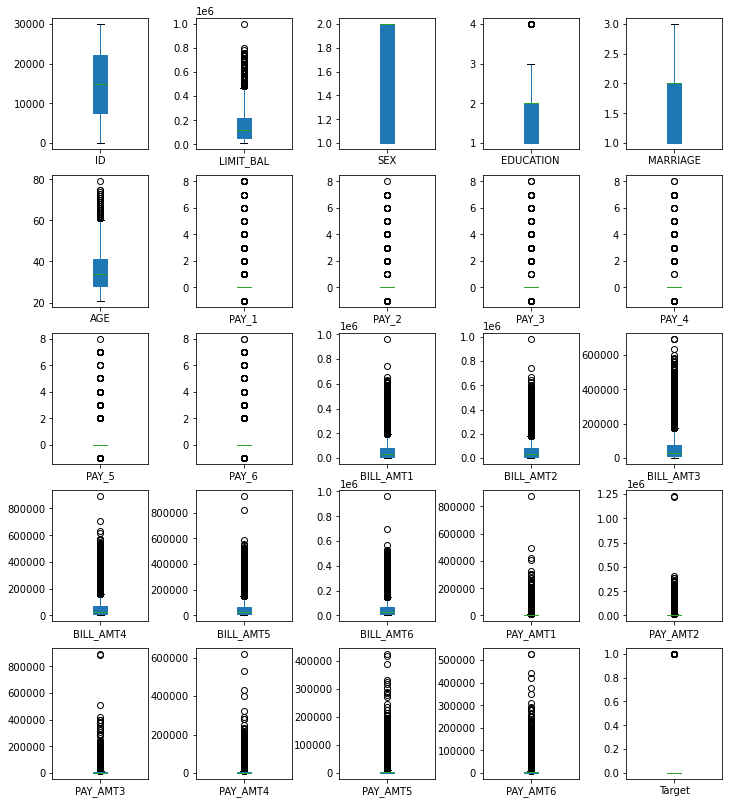

In [17]:
# subplots
plt.figure(figsize=(15,10))
df.plot(subplots=True, layout=(5,5), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);
plt.show()

## Cek Imbalance dataset

In [18]:
## melihat komposisi kolom feature target
df['Target'].value_counts()/len(df)

0    0.766333
1    0.233667
Name: Target, dtype: float64

##### Dapat dipastikan bahwa dataset ini merupakan dataset detektor yang diperuntukkan mencari nasabah yang 'default payment' bulan depan, atau menunggak bulan depan. Sehingga yang menjadi concern dari model data ini adalah True Positif (1), dan menurunkan data yang diprediksi tidak menunggak, padahal aktualnya menunggak (false negatif). Parameter yang diperhatikan adalah recall poisitf(1) dan f1-score


In [19]:
#menghapus kolom ID
del df['ID']

In [20]:
#melihat jumlah baris dan kolom
df.shape

(22455, 24)

# Exploratory Data Analysis (EDA)

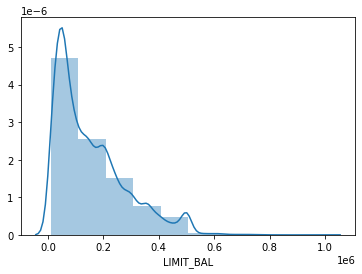

In [29]:
sns.distplot(df['LIMIT_BAL'],bins=10)
plt.show()

##### Insight :
- Pengguna Credit Card bank ini memiliki limit balance paling banyak disekitar 10K-200k

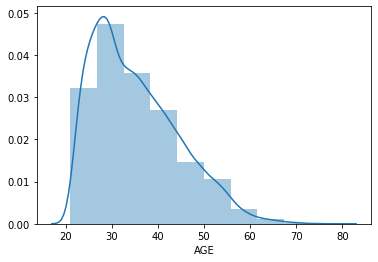

In [58]:
sns.distplot(df['AGE'],bins=10)
plt.show()

##### insight:
- Pengguna credit card dari bank ini mayoritas berusia 20-40 tahun

In [30]:
pd.crosstab(index=df['MARRIAGE'], columns=df['Target'], margins='all')

Target,0,1,All
MARRIAGE,,,
1,7523,2508,10031
2,9497,2666,12163
3,188,73,261
All,17208,5247,22455


In [45]:
pd.crosstab(index=[df['MARRIAGE'],df['SEX']], columns=df['Target'],margins=True,normalize=True)

Target               0         1       All
MARRIAGE SEX                              
1        1    0.126163  0.047384  0.173547
         2    0.208862  0.064306  0.273169
2        1    0.174304  0.054643  0.228947
         2    0.248631  0.064084  0.312714
3        1    0.003295  0.001559  0.004854
         2    0.005077  0.001692  0.006769
All           0.766333  0.233667  1.000000

##### insight 
- Pengguna cc ini mayoritas berstatus single dan bergender female

In [41]:
pd.crosstab(index=df['EDUCATION'], columns=df['Target'],normalize=True,margins=True)

Target,0,1,All
EDUCATION,,,
1,0.259898,0.063950,0.323848
2,0.375462,0.124471,0.499933
3,0.128034,0.045112,0.173146
4,0.002939,0.000134,0.003073
All,0.766333,0.233667,1.000000


##### insight 
- Pengguna credit card ini mayoritas memiliki latar belakang lulusan University

In [25]:
pd.crosstab(index=df['SEX'], columns=df['Target'])

Target,0,1
SEX,,
1,6821,2326
2,10387,2921


##### insight 
- Pengguna credit card ini mayoritas bergender perempuan


In [26]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Target'],
      dtype='object')

In [52]:
df.groupby(['Target','SEX']).agg({'BILL_AMT1':('mean','max'),'BILL_AMT2':('mean','max'),'BILL_AMT3':('mean','max'),'BILL_AMT4':('mean','max'),'BILL_AMT5':('mean','max'),'BILL_AMT6':('mean','max')}).round(2)

BILL_AMT1         BILL_AMT2         BILL_AMT3         BILL_AMT4  \
                mean     max      mean     max      mean     max      mean   
Target SEX                                                                   
0      1    66093.11  746814  63797.48  646770  60848.43  693131  56293.49   
       2    62621.59  964511  60845.73  983931  58585.18  689627  54448.31   
1      1    57962.92  613860  57206.37  572834  54888.43  519267  51770.80   
       2    56994.97  589654  56488.38  581775  54931.11  578971  51557.21   

                   BILL_AMT5         BILL_AMT6          
               max      mean     max      mean     max  
Target SEX                                              
0      1    628699  52036.60  823540  50207.00  699944  
       2    891586  50992.17  927171  49081.78  961664  
1      1    518741  49189.64  547880  47840.12  514975  
       2    548020  48528.24  530672  46603.73  498316

In [54]:
df.groupby(['Target','SEX']).agg({'LIMIT_BAL':'mean'})

LIMIT_BAL
Target SEX               
0      1    165047.646973
       2    168947.338019
1      1    112419.466896
       2    116210.201986

In [62]:
df.groupby(['Target','SEX']).agg({'PAY_AMT1':('mean','max'),'PAY_AMT2':('mean','max'),'PAY_AMT3':('mean','max'),'PAY_AMT4':('mean','max'),'PAY_AMT5':('mean','max'),'PAY_AMT6':('mean','max')}).round(2)

PAY_AMT1         PAY_AMT2          PAY_AMT3         PAY_AMT4  \
               mean     max     mean      max     mean     max     mean   
Target SEX                                                                
0      1    6778.04  423903  6723.93   388126  6143.36  417588  5497.86   
       2    6636.28  873552  6727.76  1227082  5963.03  896040  5444.09   
1      1    3752.02  244500  3647.06   358689  3941.40  508229  3435.60   
       2    3678.77  300000  3613.52   302000  3388.29  234456  3295.18   

                   PAY_AMT5         PAY_AMT6          
               max     mean     max     mean     max  
Target SEX                                            
0      1    528897  5694.56  326889  5768.73  527143  
       2    621000  5343.08  426529  5654.56  528666  
1      1    432130  3537.92  332000  3544.90  254000  
       2    235075  3222.12  287982  3643.78  287982

##### insight
- Yang memiliki tagihan dan limit lebih tinggi memiliki kecenderungan untuk membayar tepat waktu.

In [51]:
df.groupby(['Target','SEX']).agg({'AGE':'mean'})

AGE
Target SEX           
0      1    36.372379
       2    34.418408
1      1    36.505589
       2    34.536802

##### insight
- rata-rata umur yang default payment dan non default payment sama.

In [58]:
df.groupby(['MARRIAGE','SEX']).agg({'LIMIT_BAL':('mean','count')})

LIMIT_BAL      
                       mean count
MARRIAGE SEX                     
1        1    176209.905055  3897
         2    161712.748614  6134
2        1    134508.399144  5141
         2    155005.696383  7022
3        1     83302.752294   109
         2     91513.157895   152

##### insight
- Pria yang sudah menikah memiliki limit balance yang lebih tinggi, Pria yang belum menikah memiliki limit balance yang lebih rendah.

In [66]:
df.groupby(['Target']).agg({'PAY_1':('sum','mean'),'PAY_2':('sum','mean'),'PAY_3':('sum','mean'),'PAY_4':('sum','mean'),'PAY_5':('sum','mean'),'PAY_6':('sum','mean')}).round(2)

PAY_1       PAY_2       PAY_3       PAY_4       PAY_5       PAY_6      
         sum  mean   sum  mean   sum  mean   sum  mean   sum  mean   sum  mean
Target                                                                        
0       -461 -0.03   303  0.02   355  0.02   -82 -0.00  -605 -0.04  -535 -0.03
1       4664  0.89  4401  0.84  3923  0.75  3480  0.66  3059  0.58  2902  0.55

#### Insight
- Paling banyak delay di bulan agustus(pay_2) sejumlah 4703

# MACHINE LEARNING MODEL - CLASSIFICATION 

# SPLIT DATA

In [33]:
X=df.drop(columns=['Target'])
y=df['Target']

In [34]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .20, random_state = 42)

# BASE MODEL - PIPELINE

In [35]:
num_columns = ['AGE','LIMIT_BAL','PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_columns = ['SEX','EDUCATION','MARRIAGE']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_SVC = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC())
])

pipe_LogReg = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression())
])

pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

## SVC - Base Model 

In [36]:
pipe_SVC.fit(X_train,y_train)

Y_pred_SVC_base= pipe_SVC.predict(X_test)
Y_pred_SVC_base_tr=pipe_SVC.predict(X_train)

SVC_acc_base_train = accuracy_score(y_train, Y_pred_SVC_base_tr)
SVC_acc_base_ts = accuracy_score(y_test, Y_pred_SVC_base)
SVC_rec_base_train = recall_score(y_train, Y_pred_SVC_base_tr)
SVC_rec_base_ts = recall_score(y_test, Y_pred_SVC_base)
SVC_prec_base_train = precision_score(y_train, Y_pred_SVC_base_tr)
SVC_prec_base_ts = precision_score(y_test, Y_pred_SVC_base)
SVC_f1_base_train = f1_score(y_train, Y_pred_SVC_base_tr)
SVC_f1_base_ts = f1_score(y_test, Y_pred_SVC_base)

print(classification_report(y_test, Y_pred_SVC_base))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3442
           1       0.00      0.00      0.00      1049

    accuracy                           0.77      4491
   macro avg       0.38      0.50      0.43      4491
weighted avg       0.59      0.77      0.67      4491



In [37]:
cm_SVC_1 = confusion_matrix(y_test, Y_pred_SVC_base, labels=[1, 0])
df_SVC_1 = pd.DataFrame(cm_SVC_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_SVC_1

,Pred 1,Pred 0
Akt 1,0,1049
Akt 0,0,3442


## Logistic Regression - Base Model 

In [38]:
pipe_LogReg.fit(X_train,y_train)

Y_pred_logreg_base=pipe_LogReg.predict(X_test)
Y_pred_logreg_base_tr=pipe_LogReg.predict(X_train)

LR_acc_base_train = accuracy_score(y_train, Y_pred_logreg_base_tr)
LR_acc_base_ts = accuracy_score(y_test, Y_pred_logreg_base)
LR_rec_base_train = recall_score(y_train, Y_pred_logreg_base_tr)
LR_rec_base_ts = recall_score(y_test, Y_pred_logreg_base)
LR_prec_base_train = precision_score(y_train, Y_pred_logreg_base_tr)
LR_prec_base_ts = precision_score(y_test, Y_pred_logreg_base)
LR_f1_base_train = f1_score(y_train, Y_pred_logreg_base_tr)
LR_f1_base_ts = f1_score(y_test, Y_pred_logreg_base)

print(classification_report(y_test, Y_pred_logreg_base))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3442
           1       0.67      0.00      0.00      1049

    accuracy                           0.77      4491
   macro avg       0.72      0.50      0.44      4491
weighted avg       0.74      0.77      0.67      4491



In [39]:
cm_LR_1 = confusion_matrix(y_test, Y_pred_logreg_base, labels=[1, 0])
df_LR_1 = pd.DataFrame(cm_LR_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_LR_1

,Pred 1,Pred 0
Akt 1,2,1047
Akt 0,1,3441


## Random Forest - Base Model

In [40]:
pipe_RF.fit(X_train,y_train)

y_pred_RF_base=pipe_RF.predict(X_test)
y_pred_RF_base_tr=pipe_RF.predict(X_train)

RF_acc_base_train = accuracy_score(y_train, y_pred_RF_base_tr)
RF_acc_base_ts = accuracy_score(y_test, y_pred_RF_base)
RF_rec_base_train = recall_score(y_train, y_pred_RF_base_tr)
RF_rec_base_ts = recall_score(y_test, y_pred_RF_base)
RF_prec_base_train = precision_score(y_train, y_pred_RF_base_tr)
RF_prec_base_ts = precision_score(y_test, y_pred_RF_base)
RF_f1_base_train = f1_score(y_train, y_pred_RF_base_tr)
RF_f1_base_ts = f1_score(y_test, y_pred_RF_base)

print(classification_report(y_test, y_pred_RF_base))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3442
           1       0.68      0.44      0.53      1049

    accuracy                           0.82      4491
   macro avg       0.76      0.69      0.71      4491
weighted avg       0.81      0.82      0.80      4491



In [41]:
cm_RF_1 = confusion_matrix(y_test, y_pred_RF_base, labels=[1, 0])
df_RF_1 = pd.DataFrame(cm_RF_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_RF_1

,Pred 1,Pred 0
Akt 1,459,590
Akt 0,220,3222


# FEATURE SELECTION - Corelation Ratio n Assosiation

In [42]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Target'],
      dtype='object')

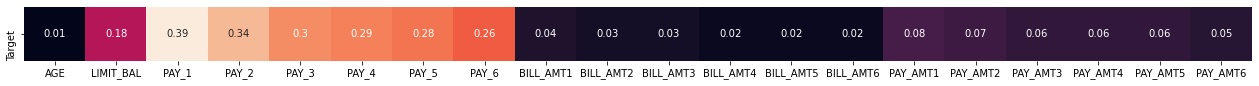

In [43]:
cor_ratio = []
numeric=['AGE','LIMIT_BAL','PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for i in numeric:
    cor= round(correlation_ratio(df['Target'], df[i]), 2)
    cor_ratio.append(cor)

data_cr = pd.DataFrame(data = [cor_ratio],index = ['Target'],columns=['AGE','LIMIT_BAL','PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_cr, annot=True, cbar=False)
plt.show()

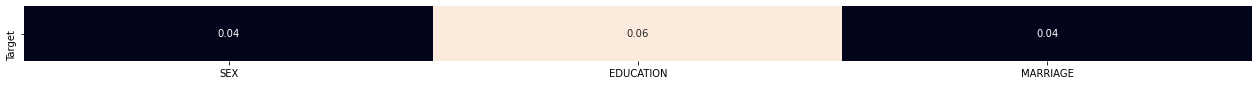

In [44]:
cramers = []
cat=['SEX','EDUCATION','MARRIAGE']


for i in cat:
    cram= round(cramers_v(df['Target'], df[i]), 2)
    cramers.append(cram)

data_cram = pd.DataFrame(data = [cramers],index = ['Target'],columns=['SEX','EDUCATION','MARRIAGE'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_cram, annot=True, cbar=False)
plt.show()

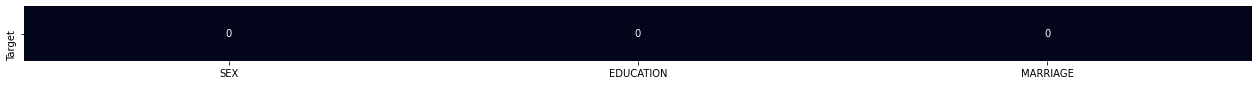

In [45]:
theils = []
cat=['SEX','EDUCATION','MARRIAGE']


for i in cat:
    th= round(theils_u(df['Target'], df[i]), 2)
    theils.append(th)

data_th = pd.DataFrame(data = [theils],index = ['Target'],columns=['SEX','EDUCATION','MARRIAGE'])

plt.figure(figsize=(22, 1))
sns.heatmap(data_th, annot=True, cbar=False)
plt.show()

#### Berdasarkan corelation_ratio dan asosiasi dari dataset ini. feature sex, edu,marriage, dan age tidak begitu berpengaruh dalam feature Target 

In [46]:
df_1=df.copy()
df_1.drop(columns=['SEX','EDUCATION','MARRIAGE','AGE'],inplace=True)

# SPLIT DATA

In [47]:
X_1=df_1.drop(columns=['Target'])
y_1=df_1['Target']

In [48]:
# Splitting
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, stratify=y_1, test_size = .20, random_state = 42)

# PIPELINE ft (Feature Engineering, Feature Selection)

In [49]:
num_columns = ['LIMIT_BAL','PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
     ('scaler', RobustScaler()),
     ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])


preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns)
])

pipe_SVC_1 = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(class_weight={0:.15,1:.85},max_iter=300))
])

pipe_LogReg_1 = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression(class_weight={0:.15,1:.85}))
])

pipe_RF_1 = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(class_weight={0:.15,1:.85}))
])

## SVC - Pipeline2

In [50]:
pipe_SVC_1.fit(X1_train,y1_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['LIMIT_BAL', 'PAY_1',
                                                   'PAY_2', 'PAY_3', 'PAY_4',
                                                   'PAY_5', 'PAY_6',
                                                   'BILL_AMT1', 'BILL_AMT2',
            

In [51]:
Y_pred_SVC_1= pipe_SVC_1.predict(X1_test)
Y_pred_SVC_1_tr=pipe_SVC_1.predict(X1_train)

SVC_acc_1_train = accuracy_score(y1_train, Y_pred_SVC_1_tr)
SVC_acc_1_ts = accuracy_score(y1_test, Y_pred_SVC_1)
SVC_rec_1_train = recall_score(y1_train, Y_pred_SVC_1_tr)
SVC_rec_1_ts = recall_score(y1_test, Y_pred_SVC_1)
SVC_prec_1_train = precision_score(y1_train, Y_pred_SVC_1_tr)
SVC_prec_1_ts = precision_score(y1_test, Y_pred_SVC_1)
SVC_f1_1_train = f1_score(y1_train, Y_pred_SVC_1_tr)
SVC_f1_1_ts = f1_score(y1_test, Y_pred_SVC_1)

print(classification_report(y1_test, Y_pred_SVC_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3442
           1       0.23      1.00      0.38      1049

    accuracy                           0.23      4491
   macro avg       0.12      0.50      0.19      4491
weighted avg       0.05      0.23      0.09      4491



In [52]:
cm_SVC_1 = confusion_matrix(y1_test, Y_pred_SVC_1, labels=[1, 0])
df_SVC_1 = pd.DataFrame(cm_SVC_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_SVC_1

,Pred 1,Pred 0
Akt 1,1049,0
Akt 0,3442,0


## Logistic Regression - PIPELINE2

In [53]:
pipe_LogReg_1.fit(X1_train,y1_train)

Y_pred_logreg_1=pipe_LogReg_1.predict(X1_test)
Y_pred_logreg_1_tr=pipe_LogReg_1.predict(X1_train)

LR_acc_1_train = accuracy_score(y1_train, Y_pred_logreg_1_tr)
LR_acc_1_ts = accuracy_score(y1_test, Y_pred_logreg_1)
LR_rec_1_train = recall_score(y1_train, Y_pred_logreg_1_tr)
LR_rec_1_ts = recall_score(y1_test, Y_pred_logreg_1)
LR_prec_1_train = precision_score(y1_train, Y_pred_logreg_1_tr)
LR_prec_1_ts = precision_score(y1_test, Y_pred_logreg_1)
LR_f1_1_train = f1_score(y1_train, Y_pred_logreg_1_tr)
LR_f1_1_ts = f1_score(y1_test, Y_pred_logreg_1)

print(classification_report(y1_test, Y_pred_logreg_1))

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      3442
           1       0.30      0.83      0.44      1049

    accuracy                           0.50      4491
   macro avg       0.59      0.61      0.49      4491
weighted avg       0.75      0.50      0.52      4491



In [54]:
cm_LR_1 = confusion_matrix(y1_test, Y_pred_logreg_1, labels=[1, 0])
df_LR_1 = pd.DataFrame(cm_LR_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_LR_1

,Pred 1,Pred 0
Akt 1,869,180
Akt 0,2073,1369


## Random Forest - PIPELINE2

In [55]:
pipe_RF_1.fit(X1_train,y1_train)

y_pred_RF_1=pipe_RF_1.predict(X1_test)
y_pred_RF_1_tr=pipe_RF_1.predict(X1_train)

RF_acc_1_train = accuracy_score(y1_train, y_pred_RF_1_tr)
RF_acc_1_ts = accuracy_score(y1_test, y_pred_RF_1)
RF_rec_1_train = recall_score(y1_train, y_pred_RF_1_tr)
RF_rec_1_ts = recall_score(y1_test, y_pred_RF_1)
RF_prec_1_train = precision_score(y1_train, y_pred_RF_1_tr)
RF_prec_1_ts = precision_score(y1_test, y_pred_RF_1)
RF_f1_1_train = f1_score(y1_train, y_pred_RF_1_tr)
RF_f1_1_ts = f1_score(y1_test, y_pred_RF_1)

print(classification_report(y1_test, y_pred_RF_1))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3442
           1       0.66      0.37      0.47      1049

    accuracy                           0.81      4491
   macro avg       0.75      0.65      0.68      4491
weighted avg       0.79      0.81      0.79      4491



In [56]:
cm_RF_1 = confusion_matrix(y1_test, y_pred_RF_1, labels=[1, 0])
df_RF_1 = pd.DataFrame(cm_RF_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_RF_1

,Pred 1,Pred 0
Akt 1,385,664
Akt 0,198,3244


# HYPERPARAMETER TUNING 

# Hyparameter Tuning - Handling Imbalance - Class Weight 

In [63]:
num_columns = ['LIMIT_BAL','PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
])


pipe_SVC_pol = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(max_iter=100))
])

pipe_LogReg_pol = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression())
])

pipe_RF_pol = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

## SVC Tuning 

In [64]:
# pipe_SVC_pol.get_params()

In [ ]:
param_SVC = {
    'algo__C': np.arange(1, 20, 10),
    'algo__class_weight': ["balanced",{0:0.15,1:0.85},{0:1,1:0.9},],
    "algo__gamma" : np.arange(1, 20, 5),
}

In [ ]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [ ]:
SVC_tune = RandomizedSearchCV(pipe_SVC_pol, param_SVC,n_iter=50, cv = skf, scoring = 'f1', n_jobs = -1, verbose=1,random_state=42)

In [ ]:
SVC_tune.fit(X1_train, y1_train)

In [ ]:
SVC_tune.best_params_

In [ ]:
SVC_tune_1=SVC_tune.best_estimator_

Y_pred_SVC=SVC_tune_1.predict(X1_test)
Y_pred_SVC_tr=SVC_tune_1.predict(X1_train)

SVC_acc_train = accuracy_score(y1_train, Y_pred_SVC_tr)
SVC_acc_ts = accuracy_score(y1_test, Y_pred_SVC)
SVC_rec_train = recall_score(y1_train, Y_pred_SVC_tr)
SVC_rec_ts = recall_score(y1_test, Y_pred_SVC)
SVC_prec_train = precision_score(y1_train, Y_pred_SVC_tr)
SVC_prec_ts = precision_score(y1_test, Y_pred_SVC)
SVC_f1_train = f1_score(y1_train, Y_pred_SVC_tr)
SVC_f1_ts = f1_score(y1_test, Y_pred_SVC)

print(classification_report(y1_test, Y_pred_SVC))

In [ ]:
cm_SVC_2 = confusion_matrix(y1_test, Y_pred_SVC, labels=[1, 0])
df_SVC_2 = pd.DataFrame(cm_SVC_2, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_SVC_2

## Logistioc Regression Tuning 

In [69]:
# pipe_LogReg_pol.get_params()

In [70]:
param_LR = {
    'algo__C': np.logspace(-7 , 3, 20),
    'algo__class_weight': [None,{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.15,1:0.85}],
    'algo__penalty': ['l1', 'l2', 'elasticnet']
}

In [71]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [72]:
LR_tune=GridSearchCV(pipe_LogReg_pol, param_LR, cv = skf, scoring='f1', n_jobs=-1, verbose=1)

In [73]:
LR_tune.fit(X1_train, y1_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  9.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(degree=3,
                                                                                                             include_bias=False))]),
                                                                         ['LIMIT_BAL',
                                                                          'PAY_1',
                                                              

In [74]:
LR_tune.best_params_

{'algo__C': 1.274274985703132e-05,
 'algo__class_weight': {0: 0.15, 1: 0.85},
 'algo__penalty': 'l2'}

In [75]:
LR_tune_1=LR_tune.best_estimator_

Y_pred_logreg=LR_tune_1.predict(X1_test)
Y_pred_logreg_tr=LR_tune_1.predict(X1_train)

LR_acc_train = accuracy_score(y1_train, Y_pred_logreg_tr)
LR_acc_ts = accuracy_score(y1_test, Y_pred_logreg)
LR_rec_train = recall_score(y1_train, Y_pred_logreg_tr)
LR_rec_ts = recall_score(y1_test, Y_pred_logreg)
LR_prec_train = precision_score(y1_train, Y_pred_logreg_tr)
LR_prec_ts = precision_score(y1_test, Y_pred_logreg)
LR_f1_train = f1_score(y1_train, Y_pred_logreg_tr)
LR_f1_ts = f1_score(y1_test, Y_pred_logreg)

print(classification_report(y1_test, Y_pred_logreg))

              precision    recall  f1-score   support

           0       0.81      0.67      0.74      3442
           1       0.32      0.50      0.39      1049

    accuracy                           0.63      4491
   macro avg       0.56      0.58      0.56      4491
weighted avg       0.70      0.63      0.65      4491



In [76]:
cm_LR_2 = confusion_matrix(y1_test, Y_pred_logreg, labels=[1, 0])
df_LR_2 = pd.DataFrame(cm_LR_2, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_LR_2

,Pred 1,Pred 0
Akt 1,522,527
Akt 0,1135,2307


## Random Forest Tuning

In [77]:
# pipe_RF_pol.get_params()

In [78]:
param_rf={
    'algo__class_weight': [None,{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.15,1:0.85},{0:1,1:0.9}],
    'algo__max_depth': [None,np.arange(2,50,5)], 
     'algo__max_features': ['auto',0.7,0.8,0.9],
    'algo__min_samples_leaf': np.arange(2,50,4),
     'algo__min_samples_split': np.arange(2,50,4), 
    'algo__n_estimators':np.arange(100, 2001,150),
}

In [79]:
skf = StratifiedKFold(n_splits=3, random_state=42)

In [80]:
RF_tune = RandomizedSearchCV(pipe_RF_pol, param_rf,n_iter=50, cv = skf, scoring = 'f1', n_jobs = -1, verbose=1,random_state=42)

In [ ]:
RF_tune.fit(X1_train, y1_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
RF_tune.best_params_

In [ ]:
RF_tune_1=RF_tune.best_estimator_

Y_pred_rf=RF_tune_1.predict(X1_test)
Y_pred_rf_tr=RF_tune_1.predict(X1_train)

rf_acc_train = accuracy_score(y1_train, Y_pred_rf_tr)
rf_acc_ts = accuracy_score(y1_test, Y_pred_rf)
rf_rec_train = recall_score(y1_train, Y_pred_rf_tr)
rf_rec_ts = recall_score(y1_test, Y_pred_rf)
rf_prec_train = precision_score(y1_train, Y_pred_rf_tr)
rf_prec_ts = precision_score(y1_test, Y_pred_rf)
rf_f1_train = f1_score(y1_train, Y_pred_rf_tr)
rf_f1_ts = f1_score(y1_test, Y_pred_rf)

print(classification_report(y1_test, Y_pred_rf))

In [ ]:
cm_rf_2 = confusion_matrix(y1_test, Y_pred_rf, labels=[1, 0])
df_rf_2 = pd.DataFrame(cm_rf_2, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_rf_2

In [ ]:
cm_rf_tr = confusion_matrix(y1_train, Y_pred_rf_tr, labels=[1, 0])
df_rf_tr = pd.DataFrame(cm_rf_tr, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_rf_tr

# Kesimpulan EDA 
- Hanya ~23% nasabah yang default credit (delay membayar) bulan ini.
- Pria yang sudah menikah memiliki limit balance yang lebih tinggi
- Pengguna cc ini mayoritas berstatus single dan bergender female
- umur tidak begitu pengaruh
- Yang memiliki tagihan dan limit lebih tinggi memiliki kecenderungan untuk membayar tepat waktu

## Evaluation Matrix yang akan diperhatikan

##### Dataset ini merupakan dataset detektor yang diperuntukkan mencari nasabah yang 'default payment' bulan depan, atau menunggak bulan depan. Sehingga yang menjadi concern dari model data ini adalah True Positif (1), dan menurunkan data yang diprediksi tidak menunggak, padahal aktualnya menunggak (false negatif). Parameter yang diperhatikan adalah recall poisitf(1) dan f1-score
- False Negatif : Aktual Default Credit, prediksi non DC
- False Positif : Aktual non Default Credit, prediksi DC
- True Positif : Aktual dan prediksi default credit
- Tru negatif : aktual dan prediksi non default creadit

- recall positif : perbandingan antara jumlah seluruh tebakan positif dibandingkan dengan data aktual positif
- F-1 Score : Rata-rata harmonik antara recall dan precision para meter ini diperhatikan karna agar tidak terjadi perbedaan yang sangat jauh antara FN dan FP


## Penjelasan Evaluation Matrix model pilihan

In [53]:
pipe_LogReg_1.fit(X1_train,y1_train)

Y_pred_logreg_1=pipe_LogReg_1.predict(X1_test)
Y_pred_logreg_1_tr=pipe_LogReg_1.predict(X1_train)

LR_acc_1_train = accuracy_score(y1_train, Y_pred_logreg_1_tr)
LR_acc_1_ts = accuracy_score(y1_test, Y_pred_logreg_1)
LR_rec_1_train = recall_score(y1_train, Y_pred_logreg_1_tr)
LR_rec_1_ts = recall_score(y1_test, Y_pred_logreg_1)
LR_prec_1_train = precision_score(y1_train, Y_pred_logreg_1_tr)
LR_prec_1_ts = precision_score(y1_test, Y_pred_logreg_1)
LR_f1_1_train = f1_score(y1_train, Y_pred_logreg_1_tr)
LR_f1_1_ts = f1_score(y1_test, Y_pred_logreg_1)

print(classification_report(y1_test, Y_pred_logreg_1))

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      3442
           1       0.30      0.83      0.44      1049

    accuracy                           0.50      4491
   macro avg       0.59      0.61      0.49      4491
weighted avg       0.75      0.50      0.52      4491



In [54]:
cm_LR_1 = confusion_matrix(y1_test, Y_pred_logreg_1, labels=[1, 0])
df_LR_1 = pd.DataFrame(cm_LR_1, index=['Akt 1', 'Akt 0'], columns = ['Pred 1', 'Pred 0'])
df_LR_1

,Pred 1,Pred 0
Akt 1,869,180
Akt 0,2073,1369


- accuracy tidak begitu diperhatikan karna ini merupakan dattaset imbalance. yang tujuannyaadaah melihat parameter recal/precision
- memiliki jumlah data false negatif terendah dibanding model lainnya
- memiliki nilai recall tertinggi

# Rekomendasi Model 

Berdasarkan nilai recall +, jumlah data False negatif dan false positif yang dapat dilihar dari confusion matrix dan classification report. saya merekomendasikan model LogReg_1 karena dibandingkan yang lain model ini lebih unggul.

- misal sekali menelfon pelanggan itu costnya adalah 10(dollar) dan jika 1 nasabah lupa membayar cc bulan itu dimisalkan perusahaan merugi sebanyak 5000(dollar).
- maka kerugian yang dialami perusahaan bulan depan adalah sekitar 2073x10 + 180x4000=740.730
- Model ini lebih baik dibanding yang lai yang mencapai kerugian sekitar 2.000.000 lebih
- Model ini juga dipilih berdasarkan score Recall+ terbaik

# Export Model

In [ ]:
joblib.dump(pipe_LogReg_1, 'Model_DefaultCredit')

# Evaluasi Diri
- Jangan kebanyakan ngasi parameter kalo waktunya mepet. Harus paham dan mengerti kemampuan laptop.